In [1]:
import time
import win32gui
import numpy as np

import mss
import mss.tools
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from cloningCNN import CloningCNN

from pynput.keyboard import Key, Controller
import matplotlib.pyplot as plt

In [2]:
class CloningAgent:
    def __init__(self, paramsFile):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print("using cuda")
        else:
            self.device = torch.device('cpu')
        self.cloningCNN = CloningCNN()
        self.cloningCNN.load_state_dict(torch.load(paramsFile))
        self.cloningCNN.eval() # for stuff like dropout and batchnorm
        self.cloningCNN = self.cloningCNN.to(device=self.device)

        self.meanImage = np.load("data/stats/dsetMean.npy")
        self.stdImage = np.load("data/stats/dsetStd.npy")
        plt.subplot(121)
        plt.imshow(np.array(np.round(self.meanImage), dtype=np.uint8))
        plt.title("Mean image")
        plt.subplot(122)
        plt.imshow(np.array(np.round(self.stdImage), dtype=np.uint8))
        plt.title("Std image")
        # get channel means formatted like tensors
        channelMeans = self.meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
        channelStds = self.meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(channelMeans, channelStds)
        ])
        
    def getAction(self, state):
        x = self.transform(state).unsqueeze(0)
        x = x.to(device=self.device, dtype=torch.float32)  # move to device, e.g. GPU
        scores = self.cloningCNN(x).data.cpu().numpy()[0]
#         print(scores)

        return np.argmax(scores) + 1


In [3]:
class GameEnv:
    def __init__(self, windowName):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        
        self.prevGoldPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {1:Key.up, 2:Key.right, 3:Key.down, 4:Key.left}
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
#         win32gui.SetForegroundWindow(gameWindow)

        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
        
    def getScreenInfo(self):
        self.capNum += 1
        # capture screen and downscale to 180x180
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
        padded = ImageOps.expand(img, (30,38,26,18))
        resized = padded.resize((360,360), self.downsamplingMethod)
        final = resized.resize((180,180), self.downsamplingMethod)
        
        goldPixels = np.array(final.crop((158,11,170,17))) == 255
        goldPixels = goldPixels.astype(int)
        
        return (final, goldPixels)
    
    def step(self, action):
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(0.6)
        screen, goldPixels = self.getScreenInfo()
        
        # check if got reward
        reward = 0 
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0:
            reward += 10
        self.prevGoldPixels = goldPixels
        
        return reward

using cuda


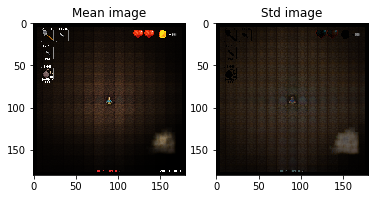

In [12]:
windowName = "Crypt of the NecroDancer"
env = GameEnv(windowName)
agent = CloningAgent("cloningCNN.pt")

In [13]:
with torch.no_grad():
    time.sleep(4)
    env.prevGoldPixels = env.getScreenInfo()[1]
    while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName:
        state, _ = env.getScreenInfo()
        action = agent.getAction(state)
        reward = env.step(action)
        print(reward)
#         time.sleep(1)
        
print("Game window no longer active. Exiting.")

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Game window no longer active. Exiting.
